In [1]:
from os import listdir
from scipy.stats.stats import spearmanr, pearsonr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
rcParams = {'font.size': 30 , 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}
plt.rcParams.update(rcParams)

In [76]:
counts_path = '/Users/harihara/Mount-2/SCRAPT/Datasets/Earth_Microbiome/Counts.soil.dict'
scrapt_path = '/Users/harihara/Mount-2/SCRAPT/Experiments/Spatil_Soil/Adaptive_With_Modeshifting/sim_0.97/alpha_0.05/'
dada2_centroid = '/Users/harihara/Mount-2/SCRAPT/Experiments/Spatil_Soil/Dada2Benchmark_8/scrapt_vs_dada2/dada2_soil_join.fna' 
dada2_results = '/Users/harihara/Mount-2/SCRAPT/Experiments/Spatil_Soil/Dada2Benchmark_8/soil_joining'
dada2_scrapt = '/Users/harihara/Mount-2/SCRAPT/Experiments/Spatil_Soil/Dada2Benchmark_8/scrapt_vs_dada2/scrapt_97_radius_99'

In [8]:
counts_path = '/Users/harihara/Mount-2/SCRAPT/Datasets/Lupus-Microbiome-Published/Counts.dict'
scrapt_path = '/Users/harihara/Mount-2/SCRAPT/Experiments/Lupus_Microbiome_MT/Adaptive_With_Modeshifting/sim_0.99/alpha_0.1/'
dada2_centroid = '/Users/harihara/Mount-2/SCRAPT/Experiments/Lupus-Microbiome-Published/DADA2_Benchmarks/by_sample_dada2_vs_scrapt/dada2vsScrapt_ap/by_sample_luo.fna'
dada2_results = '/Users/harihara/Mount-2/SCRAPT/Experiments/Lupus-Microbiome-Published/DADA2_Benchmarks/by_sample_dada2_vs_scrapt/dada2vsScrapt_ap/luo_by_sample.csv'
dada2_scrapt = '/Users/harihara/Mount-2/SCRAPT/Experiments/Lupus-Microbiome-Published/DADA2_Benchmarks/by_sample_dada2_vs_scrapt/dada2vsScrapt_ap/by_sample_s_98_r995'

In [3]:
counts_dict = eval(open(counts_path,'r').read())

In [4]:
def Parse_DNACLUST(filepath, cluster):
    op = {}
    counts = []
    centroids = []
    lines = open(filepath,'r').readlines()
    err_ctr = 0
    for l in lines:
        seqs = l.rstrip().split()
        c = seqs[0]
        for s in list(set(seqs)):
            try:
                x = op[s]
                err_ctr += 1
                continue
            except KeyError:
                pass
            op[s] = cluster
            centroids.append(c)
            try:
                counts.append(int(counts_dict[s]['Counts']))
            except KeyError:
                counts.append(1)
        cluster += 1
    print(err_ctr)
    df_scrapt_clusters = pd.DataFrame(data = {'Sequence_ID':list(op.keys()), 
                                              'Cluster_ID':list(op.values()),
                                              'Centroid':centroids,
                                              'SCRAPT_Counts':counts})
    return df_scrapt_clusters, cluster

def Load_SCRAPT_Results(data_path):
    cluster = 0
    df_scrapt = pd.DataFrame()
    for s in listdir(data_path):
        if s.startswith('Iteration'):
            print(s)
            filepath = data_path+s+'/dnaclust_mode_bait'
            df_scrapt_iter, cluster = Parse_DNACLUST(filepath, cluster)
            df_scrapt = df_scrapt.append(df_scrapt_iter, ignore_index = True)
    print(len(df_scrapt))
    df_scrapt = df_scrapt.groupby('Centroid').aggregate({'Cluster_ID':'count','SCRAPT_Counts':sum})
    return df_scrapt

def Load_DADA2_Results(seq_path, results_path):
    print(seq_path)
    print(results_path)
    buf = open(seq_path, 'r').readlines()
    op = []
    for i in range(0, len(buf), 2):
        seq_id = buf[i].replace("\n","").replace(">","")
        seq = buf[i+1].replace("\n","")
        op.append({'Centroid_id':seq_id, 'Seq':seq})
    df_centroids = pd.DataFrame(op)
    df_centroids = df_centroids.set_index('Seq')
    df_cluster_counts = pd.read_csv(results_path, sep = ";", skiprows=1, names=['Seq', 'DADA2_Counts'], 
                                    index_col = 'Seq')
    
    df_cluster_counts = df_cluster_counts.join(df_centroids)
    return df_cluster_counts.set_index('Centroid_id')[['DADA2_Counts']]


In [9]:
df_SCRAPT = Load_SCRAPT_Results(scrapt_path)
df_SCRAPT = df_SCRAPT.reset_index().rename(columns = {'Centroid':'SCRAPT_Centroid'})

Iteration_27
0
Iteration_1
7
Iteration_7
4
Iteration_32
0
Iteration_31
2
Iteration_14
2
Iteration_21
0
Iteration_23
1
Iteration_39
0
Iteration_13
2
Iteration_41
0
Iteration_15
6
Iteration_2
95
Iteration_12
4
Iteration_44
0
Iteration_22
1
Iteration_4
22
Iteration_19
1
Iteration_29
0
Iteration_42
0
Iteration_35
1
Iteration_8
8
Iteration_6
10
Iteration_43
0
Iteration_36
0
Iteration_17
1
Iteration_40
0
Iteration_48
0
Iteration_47
0
Iteration_24
0
Iteration_9
7
Iteration_20
0
Iteration_49
0
Iteration_33
0
Iteration_10
3
Iteration_37
0
Iteration_34
0
Iteration_25
1
Iteration_11
5
Iteration_30
1
Iteration_45
0
Iteration_46
0
Iteration_28
0
Iteration_0
95
Iteration_3
14
Iteration_16
1
Iteration_18
1
Iteration_5
22
Iteration_38
0
Iteration_26
1
668676


In [13]:
df_DADA2 = Load_DADA2_Results(dada2_centroid, dada2_results)
df_DADA2 = df_DADA2.reset_index().rename(columns = {'Centroid_id':'DADA2_Centroid'})
df_DADA2 = df_DADA2.set_index('DADA2_Centroid')
print(df_DADA2['DADA2_Counts'].max())
print(df_SCRAPT['SCRAPT_Counts'].max())

/Users/harihara/Mount-2/SCRAPT/Experiments/Lupus-Microbiome-Published/DADA2_Benchmarks/by_sample_dada2_vs_scrapt/dada2vsScrapt_ap/by_sample_luo.fna
/Users/harihara/Mount-2/SCRAPT/Experiments/Lupus-Microbiome-Published/DADA2_Benchmarks/by_sample_dada2_vs_scrapt/dada2vsScrapt_ap/luo_by_sample.csv
467701
962180


In [79]:
lines = open(dada2_scrapt).readlines()
op = []
for l in lines:
    seqs = l.rstrip().split()
    d = {}
    centroid = seqs[0]
    for s in seqs[1:]:
        op.append({'DADA2_Centroid':centroid, 'SCRAPT_Centroid':s})
df_map = pd.DataFrame(op)

In [80]:
df_SCRAPT_MAP = pd.merge(df_SCRAPT, df_map, on = 'SCRAPT_Centroid', how = 'left')
df_SCRAPT_MAP = df_SCRAPT_MAP.groupby('DADA2_Centroid').max()[['SCRAPT_Counts']]

In [103]:
df_temp = df_SCRAPT_MAP.join(df_DADA2, how = 'outer')

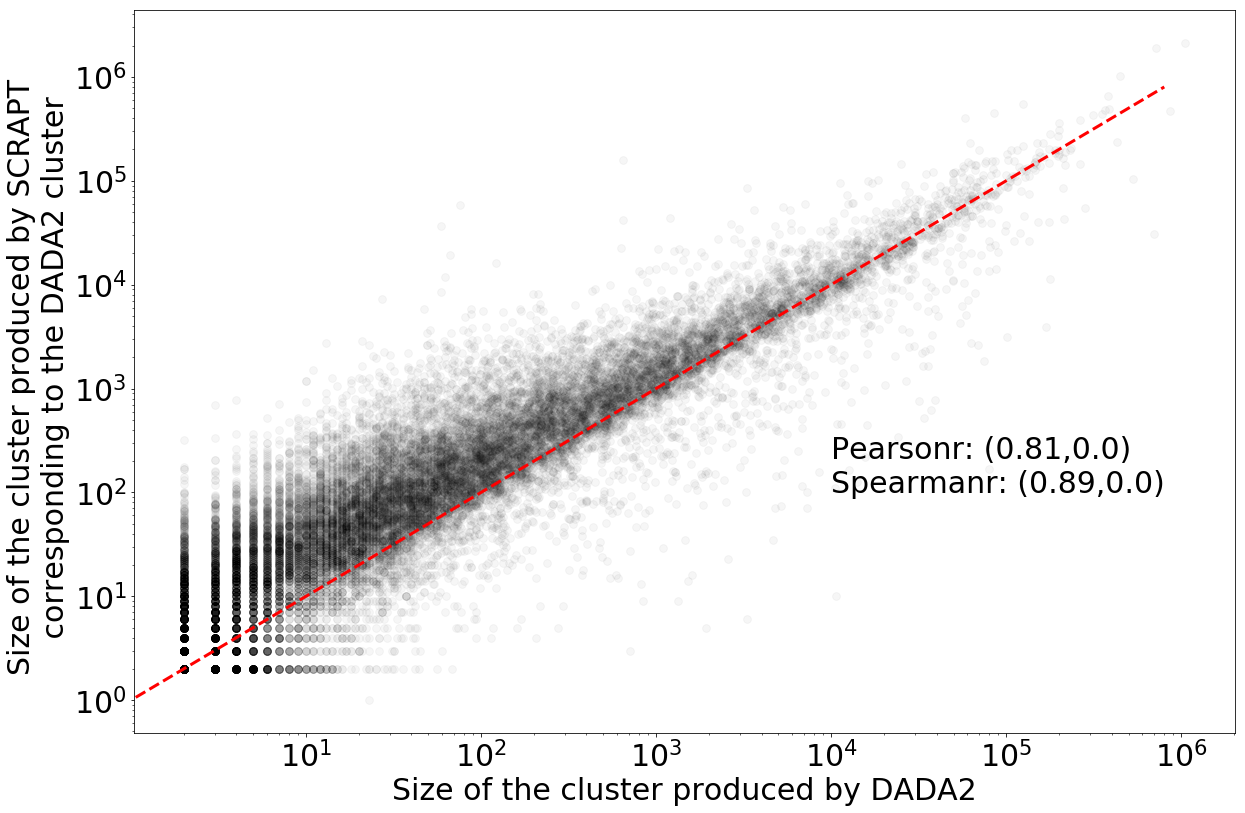

In [104]:
plt.rcParams.update(rcParams)
fig, ax = plt.subplots(1,1,figsize = (18,12))
df_temp.plot.scatter('DADA2_Counts','SCRAPT_Counts', s = 60, ax = ax, color = 'black', alpha = 0.035)
ax.plot([0,800000], [0,800000], color = 'red', linestyle = '--', linewidth = 3.0)
ax.set_xlabel('Size of the cluster produced by DADA2')
ax.set_ylabel('Size of the cluster produced by SCRAPT \n corresponding to the DADA2 cluster')
ax.set_xscale('log')
ax.set_yscale('log')
fig.tight_layout()
df_temp = df_temp.dropna()

pearson_r = round(pearsonr(df_temp['DADA2_Counts'], df_temp['SCRAPT_Counts'])[0], 2)
pearson_p = round(pearsonr(df_temp['DADA2_Counts'], df_temp['SCRAPT_Counts'])[1])

spearman_r = round(spearmanr(df_temp['DADA2_Counts'], df_temp['SCRAPT_Counts'])[0], 2)
spearman_p = round(spearmanr(df_temp['DADA2_Counts'], df_temp['SCRAPT_Counts'])[1])

ax.text(10000, 100, 
        'Pearsonr: ('+str(pearson_r)+','+str(pearson_p)+')\nSpearmanr: ('+str(spearman_r)+','+str(spearman_p)+')')
fig.savefig('/Users/harihara/Research-Activities/Plots/Iterative_Clustering/Spatial_Soil/Comparing_DADA2_SCRAPT_0.97.pdf')
fig.savefig('/Users/harihara/Research-Activities/Plots/Iterative_Clustering/Spatial_Soil/Comparing_DADA2_SCRAPT_0.97.png', dpi = 400)
